# Setup: 

First, let's make suyre this notebook works well in both python 2 and 3, import a few common modules, ensure Matplotlib plots figures inline and prepare a function to save figures: 

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common Imports 
import numpy as np 
import pandas as pd
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 12

# Where to save the figures:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR , "images",
                        CHAPTER_ID, fig_id+".png")
    print("Saving figure: ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi = 300, format = "png")
    

- Many Machine Learning problems involve thousands or even millions of features for each training instance. 
- Not only does this make training extremely slow, it also makes it much harder to find a good solution, as we will see. 
- This problem is often referred to as the _curse fo dimensionality_. 
- Fortunately, in real- world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one. 
- For example, consider the MNIST images: The pixels on the image borders are almost always white, so you could completely drop these pixels from the training set without loosing much information. 
- How do we know this? 

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

[<matplotlib.text.Text at 0x112c337b8>, <matplotlib.text.Text at 0x113769240>]

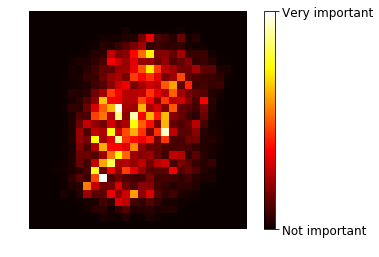

In [3]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state = 42)
rnd_clf.fit(mnist["data"],mnist["target"])
def plot_image(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
#               interpolation = "nearest"
              )
    plt.axis("off")
f_imp = rnd_clf.feature_importances_
plot_image(f_imp)
cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(),
                     rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "Very important"])

- Notice the features which are black, we can just get rid of most of them to speed up the process. 
- Moreover, two neighbouring pixels are often highly correlated: if you merge them into a single pixel (eg: by taking the mean of the two pixel intensities: _Clustering_), you will not lose much information.
- __Warning:__  
    - Reducing dimensionlaity does lose some information (just like compressing an image to `JPEG` can degrade it's quality), so even though it will speed up training, it may also make your system perform slightly wose. 
    - It also makes your pipelines a bit more complex and therefore, harder to maintain. 
    - So you should always first try to train your system with the original data before considering using dimensionality reduction if training is too slow. 
    - In some cases, however, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance ( but in general it won't, it will just speed up training). 
- Apart from speeding up training, dimensionality reduction is also extremely useful for data visualization (or `DataViz`). 
- Reducing the number of dimensions down to two (or three) makes it possible to plot a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters. 

# The Curse of dimensionlity: 

- We are so used to living in three dimensions (_well, 4 if you count time, and a few more if you're a string theorist_) that our intuition fails us when we try to imagine a high dimensional space. 
- Even a basic 4D hypercube is incredibly hard to picture in our mind, let alone a 200-dimensional ellipsoid in a 1,000 dimensional space. 
- It turns out that many things behave very differently in high-dimensional space. 
- For example, 
    - If you pick a random point in a unit square , it will have only about a 0.4% chance of being located less than 0.0001 fro a border. 
    - In other words, it is very unlikely a random point will be _"extreme"_ along any dimension. 
    - But in a 10,000 dimensional unit hypercube ( a $ 1 \times 1 \times 1 \times .... \times $ cube with 10,000 1s), the probability of picking a random _extreme_ point is $99.999999\%$. 
    - _Most points in high-dimensional hypercube are very close to border._ 
- Here is a more troublesome difference: 
    - If you pick two points randomly in a unit square, the distance between these two points will be,  on average, $0.52$. 
    - But if you pick two random points in a unit 3D cube, the average distance will be roughly $0.66$.  
    - But what about 1,000,000-dimensional hypercube? The average distance between any 2 random point in a 1million-Dimensional unit hypercube will be: $408.25$. 
    - This is counterintuitive: how can two points be so fat aprrt when they both lie in the same unit hypercube? 
    

- This fact implies that high-dimensional dataset are at a risk of being very sparse: most training instance are likely to be far away from each other.
- This also implies that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, sich they will be based on much larger _extrapolations_. 
- In short, the more dimensions a training set has, the greater the risk of overfitting it (performs well on training instances and does not generalise). 
- In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. 
- Unfortunately, in practice, the number of training instances required to reach a given density grows _exponentially_ with the number of dimensions. 
- With just 100 features (much less than MNIST problem), you would need more training instances than atoms in the observable universe in order for the training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions. 
- DOUBT: Why does it still work then? We just work with 70,000 instances and get great accuracy? 

### Main Approaches for Dimensionality Reduction: 
- Before we dive into specific dimensionality reduction algorithms, let's take a look at the two main approached to reducing dimensionality: projection and Manifold Learning. 

## Projection: 
- In most real-world problems, training instance are _not_ spread out uniformly across all dimensions. 
- Many features are almost constant while others are highly correlated (_as discussed earlier for MNIST: The outer pixels were mostly constant values close to 0, and the middle values were correlated to each other_) 
- As a result, all training instances actually lie withing (or close to) a much lower-dimensional _subspace_ of the high dimensional _subspace_. 
- This sounds very abstract, so let's look at an example. 
- Observe the following figure: 

- Notice: All training instance lie close to a plane: this a lower dimensional ($2D$) _subspace_ of the high dimensional ($3D$) _space_.
- Now, if we project every training instance perpendicularly onto this subspace (as represented by the short lines connecting the instances to the plane), we gety the new 2D dataset shown in the following figure: 

- TaDa! We just reduced the dataset's dimensionality from $3D$ to $2D$. 
- Note that the axes corresponding to the new features $z_1$ and $z_2$ ( the coordinates of the projections on the plane.

In [4]:
def mean_norm(x):
    X = x - x.mean(axis = 0)/x.std(axis = 0)
    return X

In [5]:
def svd(X):
    m = len(X)
    covar_matrix = (1/m)*X.T.dot(X)
    U, S_diag, V_T = np.linalg.svd(covar_matrix)
    return covar_matrix, U, S_diag, V_T

In [6]:
def variance_retained(X,S_diag,k):
    sum_k = np.sum(S_diag[:k])
    sum_n = np.sum(S_diag)
    var_ret = sum_k/sum_n
    return var_ret

In [7]:
def pca(X, K):
    # Normalize the input matrix
    X = mean_norm(X)
    # Find the principal components 
    covar_matrix, U , S_diag, V_T  = svd(X)
    
    # Store the variances retained 
    # Index 0 is filled with 0, so that index 1 corresponds to 
    # variance retained when k = 1
    var_ret_master = [0] 
    
    # Store the reduced dimensional arrays for k - dimensions. 
    Z_master = [[0]]
    
    # Store the directional vectors for each k - dimensions.
    U_reduce_master = [[0]]
    
    # Initial k value
    k = 1
    # Looping to find lowest k value which retains 99% of the
    # variance in X. 
    while k <= K:
        # Extract k direction vectors from U (n X k)
        U_reduce = U[:,:k]
        # Append current U_reduce to U_reduce_master: 
        U_reduce_master.append(U_reduce)
        
        # Find new(reduced) features Z (m X k)
        Z = X.dot(U_reduce) 
        
        # Append current Z to Z master
        Z_master.append(Z)
        # Calculate variance retained by using current k value
        # In other words, caculate variance retained after projecting
        # the n dimensional data into k dimensions 
        var_ret = variance_retained(X,S_diag, k)
        
        # Append variance retained using current k
        var_ret_master.append(var_ret)
        
        """        
        # Stop process if current k retains >= 99% variance
        if var_ret >= 0.99:
            break
        """
        
        # Else, repeat process using next k value
        k += 1
    
    return Z_master, U_reduce_master, var_ret_master

In [8]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
X.shape

(60, 3)

In [9]:
Z_master, U_reduce_master, var_ret_master = pca(X,2)

In [10]:
var_ret_master
# Only 97% of the variance is retained when reducing this
# 3D dataset to 2D

[0, 0.74330490711281771, 0.97828916666638488]

In [11]:
Z = Z_master[-1]
Z.shape

(60, 2)

In [12]:
U_reduce = U_reduce_master[-1]
U_reduce.shape

(3, 2)

In [13]:
X_recovered  = Z.dot(U_reduce.T)

In [14]:
(X_recovered == X).all()

False

Saving figure:  dataset3d_proj_2d


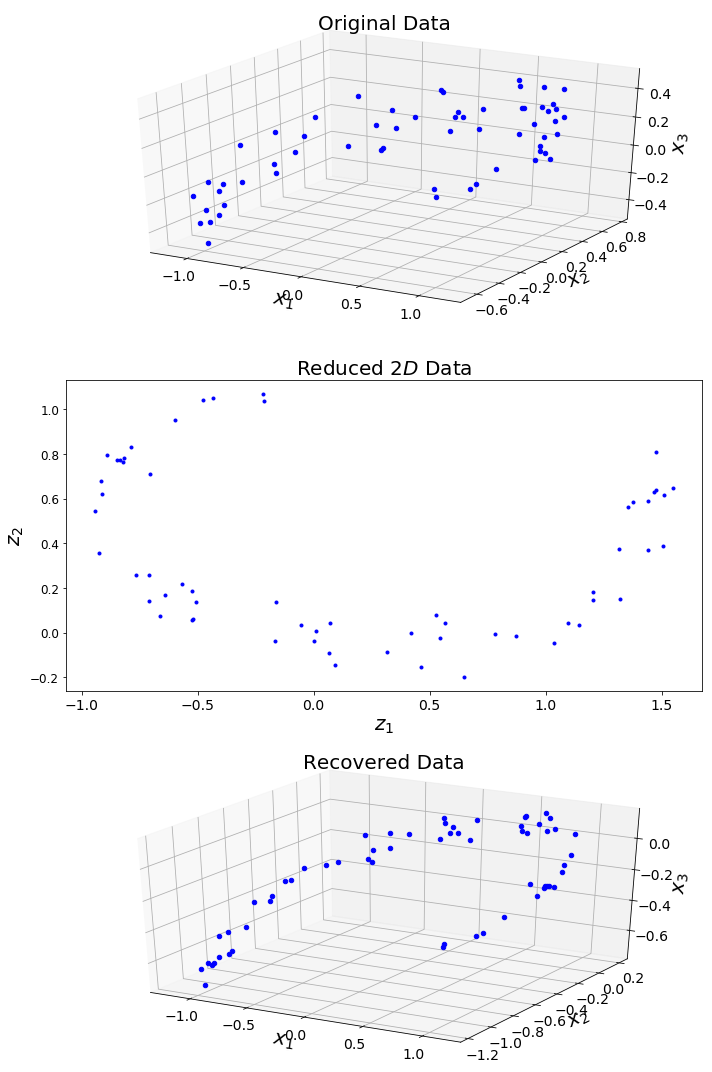

In [15]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize = (10,15))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c= "b", depthshade = False)
ax.set_xlabel(r"$x_1$", ha = "left" , fontsize = 20)
ax.set_ylabel(r"$x_2$", fontsize = 20)
ax.set_zlabel(r"$x_3$",rotation = 90 ,fontsize = 20 )
plt.title("Original Data", fontsize = 20)

plt.subplot(312)
plt.plot(Z[:,0], Z[:,1], "b.")
plt.xlabel(r"$z_1$", fontsize = 20)
plt.ylabel(r"$z_2$", fontsize = 20)
plt.title("Reduced $2D$ Data", fontsize = 20)

ax = fig.add_subplot(313, projection='3d')
ax.scatter(X_recovered[:,0], X_recovered[:,1], X_recovered[:,2],
           c= "b", depthshade = False)
ax.set_xlabel(r"$x_1$", fontsize = 20)
ax.set_ylabel(r"$x_2$", fontsize = 20)
ax.set_zlabel(r"$x_3$",rotation = 90 ,fontsize = 20 )
plt.title("Recovered Data", fontsize = 20)
save_fig("dataset3d_proj_2d")

However, projection is not always the best approach to dimensionality reduction. 
In many cases, the subspace may twist and turn, such as in the famous _Swiss roll_ toy dataset represented in the following plot: 

In [16]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples = 1000, noise = 0.2, 
                      random_state = 42)

Saving figure:  swiss_roll3D_plot


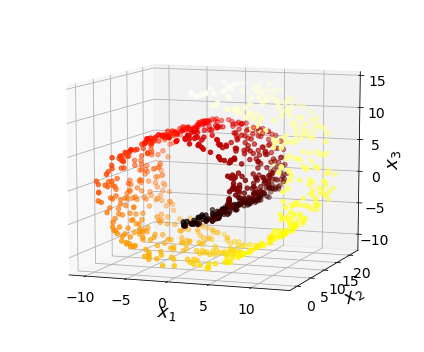

In [17]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
           c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll3D_plot")
plt.show()

In [18]:
# Reducing to 2D: 
Z_master_swiss, U_reduce_master_swiss, var_ret_master_swiss = pca(X,2)

In [19]:
var_ret_master_swiss

[0, 0.5745412867410884, 0.81689774429582351]

__Only $81\%$ of the variance in retained when using PCA on _swiss roll_ dataset __, which is quite bad as compared to $97\%$ on the previous 3D dataset, or the required $99\%$. 

In [20]:
Z_swiss = Z_master_swiss[-1]
U_reduce_swiss = U_reduce_master_swiss[-1]
Z_swiss.shape, U_reduce_swiss.shape

((1000, 2), (3, 2))

Saving figure:  swiss_roll2D_plot


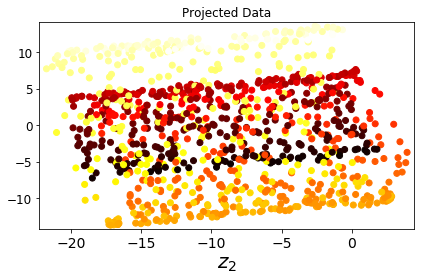

In [21]:
plt.scatter(Z_swiss[:,0], Z_swiss[:,1], c = t,
         cmap = plt.cm.hot)
plt.xlabel(r"$z_1$", fontsize = 20)
plt.xlabel(r"$z_2$", fontsize = 20)
plt.title("Projected Data")
plt.axis([Z_swiss[:,0].min() - 0.5, Z_swiss[:,0].max() + 0.5,
         Z_swiss[:,1].min() - 0.5, Z_swiss[:,1].max() + 0.5])
save_fig("swiss_roll2D_plot")

In [22]:
X_recovered_swiss = Z_swiss.dot(U_reduce_swiss.T)

Saving figure:  swiss_roll_recovered_plot


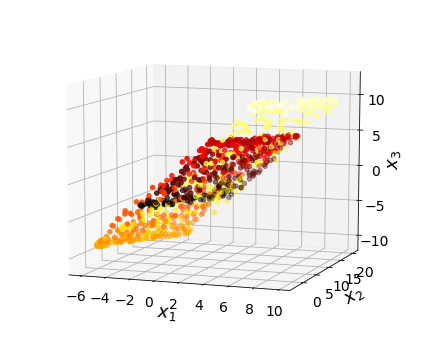

In [23]:

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_recovered_swiss[:, 0], 
           X_recovered_swiss[:, 1],
           X_recovered_swiss[:, 2], 
           c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

save_fig("swiss_roll_recovered_plot")
plt.show()

Saving figure:  swiss_proj_3D_2D_Recovered


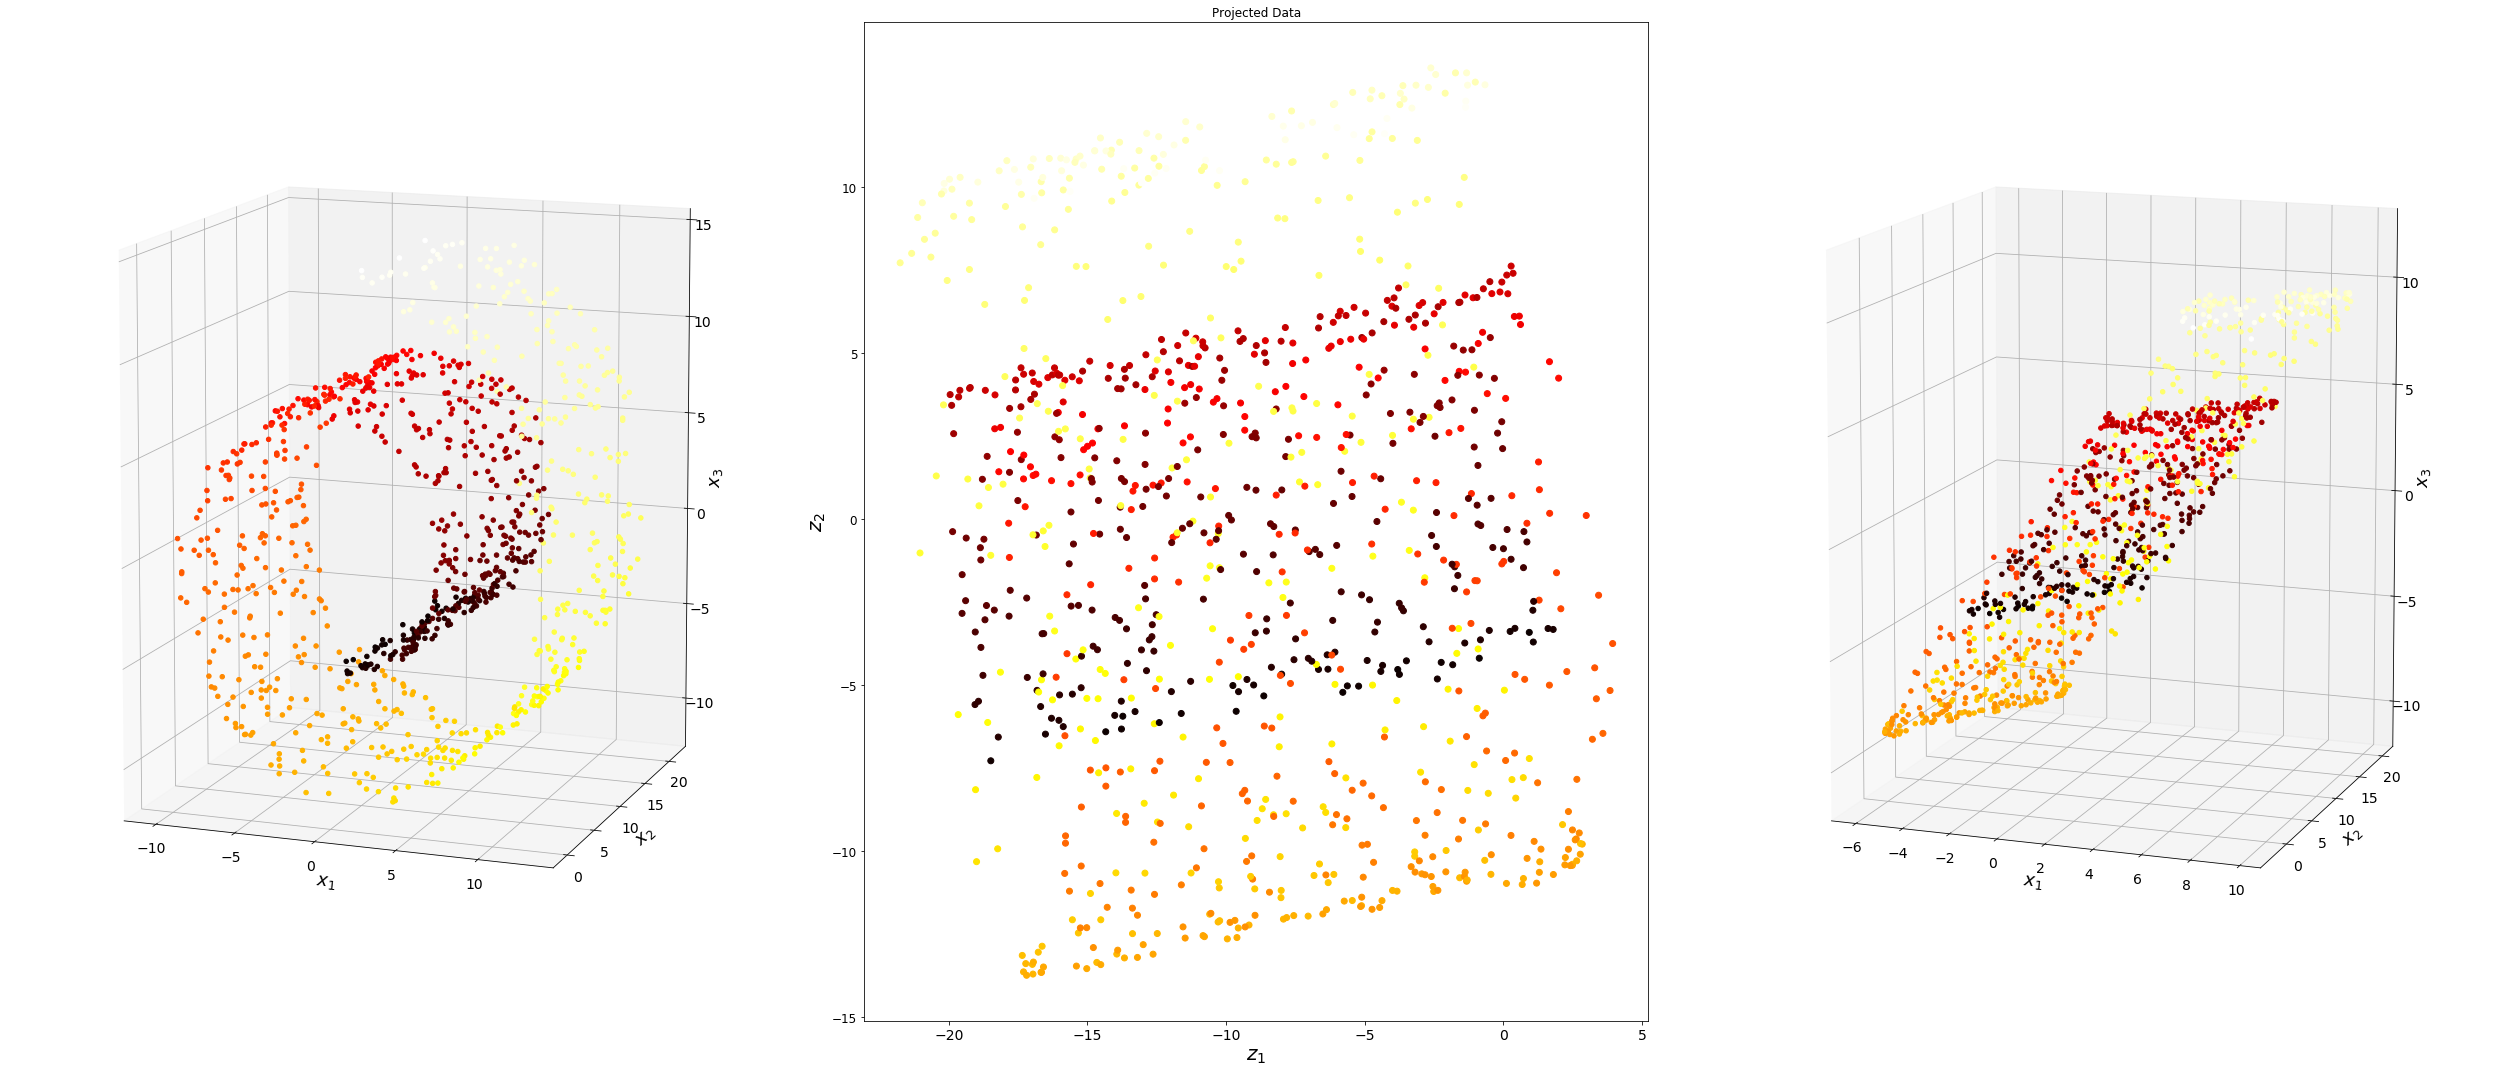

In [24]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(35, 15))
ax = fig.add_subplot(131, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
           c=t, cmap=plt.cm.hot, depthshade = False)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

ax1 = fig.add_subplot(132)
ax1.scatter(Z_swiss[:,0], Z_swiss[:,1], c = t,
         cmap = plt.cm.hot)
ax1.set_xlabel(r"$z_1$", fontsize = 20)
ax1.set_ylabel(r"$z_2$", fontsize = 20)
ax1.set_title("Projected Data")

ax2 = fig.add_subplot(133, projection = "3d")
ax2.scatter(X_recovered_swiss[:, 0], 
           X_recovered_swiss[:, 1],
           X_recovered_swiss[:, 2], 
           c=t, cmap=plt.cm.hot,
           depthshade = False)
ax2.view_init(10, -70)
ax2.set_xlabel("$x_1$", fontsize=18)
ax2.set_ylabel("$x_2$", fontsize=18)
ax2.set_zlabel("$x_3$", fontsize=18)

save_fig("swiss_proj_3D_2D_Recovered")

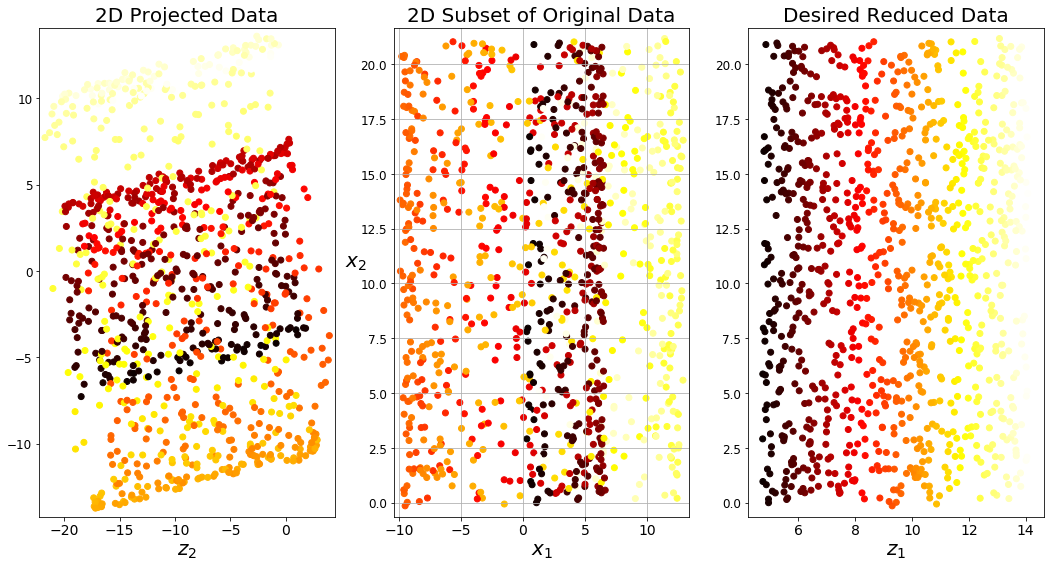

In [28]:
plt.figure(figsize = (18,9))

# Plotting the Reduced/Projected Data
plt.subplot(131)
plt.scatter(Z_swiss[:,0], Z_swiss[:,1], c = t,
         cmap = plt.cm.hot)
plt.xlabel(r"$z_1$", fontsize = 20)
plt.xlabel(r"$z_2$", fontsize = 20)
plt.title("2D Projected Data", fontsize = 20)
plt.axis([Z_swiss[:,0].min() - 0.5, Z_swiss[:,0].max() + 0.5,
         Z_swiss[:,1].min() - 0.5, Z_swiss[:,1].max() + 0.5])

# Plotting only first 2 columns of original data
plt.subplot(132)
plt.scatter(X[:,0], X[:,1], c = t, cmap = plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=20)
plt.ylabel("$x_2$", fontsize=20, rotation=0)
plt.axis([X[:,0].min() - 0.5, X[:,0].max() + 0.5,
         X[:,1].min() - 0.5, X[:,1].max() + 0.5])
plt.grid(True)
plt.title("2D Subset of Original Data", fontsize = 20)

# Plotting only the target label against the second 
# column of orginal data
plt.subplot(133)
plt.scatter(t, X[: , 1], c=t, cmap = plt.cm.hot)
plt.axis([t.min() - 0.5, t.max() + 0.5,
         X[:,1].min() - 0.5, X[:,1].max() + 0.5])
plt.title("Desired Reduced Data", fontsize = 20)
plt.xlabel("$z_1$", fontsize=20)


- As you can see in `2D Projected Data` and `2D Subset of Original Data`, simply projecting onto a plane would square different layers of the Swiss roll together. 
- However, what you really want is to unroll the _Swiss roll_ to obtrain the 2D dataset on the right. 
- Also See: http://www.astroml.org/book_figures/chapter7/fig_S_manifold_PCA.html
- The main difference between PCA and Manifold Learning is that PCA projects the whole data onto a _linear subspace_ (hyperplane) as opposed to _non-linear_ manifold. Manifold Learning _unrolls_ the data onto a lower dimensional subspace. 


### Manifold Learning: 
- The Swiss Roll is an example of a 2D _manifold_. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher dimensional space. 
- More generally, a _d - dimensional manifold_ is a part of an _n - dimensional space_ ( where _d < n_) that locally resembles a _d - dimensional hyperplane_. 
- In the case of the Swiss roll, _d=2_ and _n=3_. It locally resmbles a 2D plane, but it is rolled in to the third dimension. 
- Many dimensionality reduction algorithms work by modelling the _manifold_ on which the training instance lie, this is called _Manifold Learning_. 
- It relied on the _manifold assumption_, also called the _manifold hypothesis_, which holds that most real-wrold-high-dimensional datasets lie close to a much lower dimensional manifold. 
- This assumption is very often empirically(practically) observed. 
- Once, again, think about the MNIST dataset: 
    - All handwritten digit images have some similarities.
    - They are made of connected lines.
    - The border are white
    - They are more or less centered 
- If you random generated any ($784 \times 784$)image, only a ridiculously tiny fraction of them would look like handwritten difits. 
- In other words, the _degrees of freedom_(_The number of features used that free to vary/free to be any value_) available to you if you try to create a difit image are dramatically lower than the degrees of freedom you would have if you were allowed to generate any image you wanted.
- These constraints tend to squeexe the dataset into a lower dimensional _manifold_ (_d-dim object in an n-dim space)._
- The manifold assumption is often occompanied by another implicit assumption: 
    - The task at had (classification or regression) will be simpled if expressed in the lower dimensional space of manifold. 
- Example: 
    - in the following image: the _Swiss roll_ is split into two classes: In the 3D space, the decision boundary would be fairly complex, but in the 2D unrolled manifold space (on the right), the decision boundary is a simple straight line. 
- However, the assumption does not always hold. 
- Example:
    - In the bottom part of the image, the decision boundary is located at $x_1 = 5$. 
    - This decision boundary looks very simple in the original 3D space ( a vertical plane), but it looks more complex in the unrolled manifold ( a collection of four independent line segments). 
- In short, if you reduce the dimensionality of your training set before training a model, it will definitely speed up training, but may not always lead to better or simpler solution. It all depends on the dataset. 



Saving figure:  manifold_decision_boundary_plot1


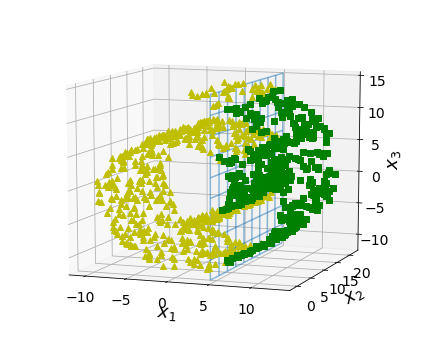

Saving figure:  manifold_decision_boundary_plot2


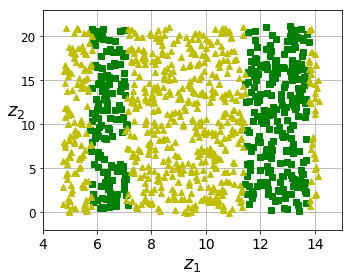

Saving figure:  manifold_decision_boundary_plot3


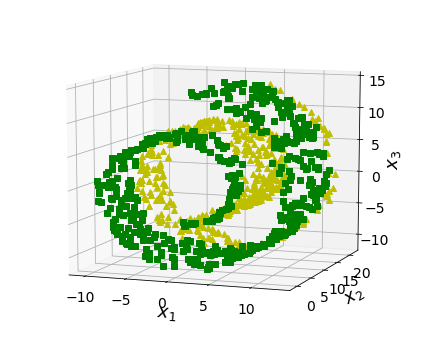

Saving figure:  manifold_decision_boundary_plot4


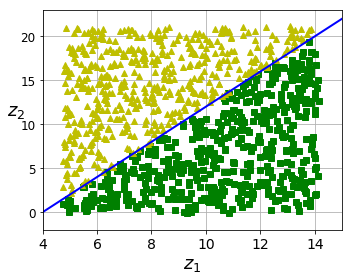

In [31]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

## PCA: 
- _Principal Component Analysis_ is by far the most popular dimensionality reduction algorithm. 
- First, it identifies the hyperplane that lies closest to the data, and then it projects the data onto it. 

###  Preserving the Variance: 
- Before you can project the training set onto a lower dimensional hyperplane, you first need to choose the right hyperplane. 
- For example, a simple 2D dataset is represented on the left of the following firgure, along with three different axes (i.e one-dimensional hyperplanes).
- On the right is the result of the projection onto each of these axes.
- As you can see, the projection onto the solid line preserves the manumum variance, while the projection on the dotted line preserves very little variance, and the projection on the dashed line preserves an intermediate amount of variance. 

Saving figure:  pca_best_projection


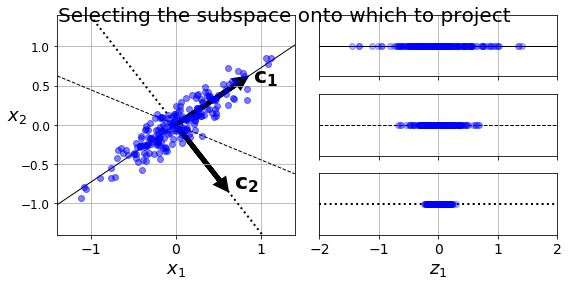

In [36]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.suptitle("Selecting the subspace onto which to project",
            fontsize = 20, va="top" )

plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


save_fig("pca_best_projection")
plt.show()

- It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. 
- Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. 
- This is the rather simple idea behind (TODO)[PCA](http://stat.smmu.edu.cn/history/pearson1901.pdf).

## Principal Components: 
- PCA identifies the axis, $C1$ that accounts for the largest amount of variance in the training set. 
- In the above figure, it is the solid line. 
- DOUBT: PCA also finds a second axis, $C2$, orthogonal to the first one, that account for the largest amount of remaining variance. 
- In this 2D example, there is no choice: it $C2$, is the dotted line. 
- If it were a higher dimensional dataset, PCA would also find a thirds axis orthogonal to both previous axes, and fourth, and a fifth, and so on - as many axes as the number of dimensions in the dataset. 
- The unit vector that defines the $i^{th}$ axis is called the $i^th$ principal component. 
- In the above figure, the $1^{st}$ principal component is $C1$ and the $2^{nd}$ is $C2$. 

- In the following figure:  
<img src = "images/dim_reduction/dataset_3d_plot.png">
- The first two principal componen ts are represented by the orthogonal arrows in the plane, and the third principal component would be orthogonal to the plane (pointint up or down). 

 __Note:__   
- The direction of the principal components is not stable, if you perturb the training set slighlt and run PCA again, some of the new principal components may point in the opposite direction of the original principal components. 
- However, they will generally lie on the same axes. 
- In some cases, a pairt of principal components may even rotate or swap, but the plane that they define will generally remain the same.   

__How will you find the principal components of a training set?__  

DOUBT: [How are PCA and SVD related](https://intoli.com/blog/pca-and-svd/)
- Luckily, there is a standard matrix factorization technique called _Singular Value Decomposition_ that can decompose the training set matrix $X$ into the dot product of three matrix $U.\Sigma.V^T$, where $V^T$ contains all the principal components that we are looking for.   

__Note:__ Earlier we were using $U$ as the matrix with all the principal components. That was because we were applying  _Singular Value Decomposition_ on the _Covariance Matrix of $X$_ , and here, we apply it directly to $X$
- The following code use Numpy's `svd()`  function to obtain all the principal components of the training set, then extracts the first two principal components. 

```python

X_centred = X - X.mean(axis = 0)
U, s, V = np.linalg.svd(X_centred)
c1 = V.T[:,0]
c2 = V.T[:,1]
```

__Warning__: PCA assumes that the dataset is centred around the origin. As we will see, Scikit-Learn's PCA classes take care of cenetering the data for you. 
- However, if you implement PCA yourself (as in the preceeding example), if you use other libraries, don't forget to centee the data first.   

DOUBT: [Why is important to center the data when using PCA](https://www.quora.com/Why-is-it-beneficial-to-center-and-normalize-the-data-before-running-Principal-Component-Analysis-on-it)  


### Projecting down to d Dimensions: 
- Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to _d_ dimensions by projecting it onto the hyperplane define by the first _d_ principal components. 
- Selecting this hyperplane ensures that the projection will preserve as much variance as possible. 
- For example, in the following figure: 
<img src = "images/dim_reduction/dataset_3d_plot.png">
- The 3D dataset is projected down to the 2D plane defined by the first two principal components, preserving a large part of the dataset's variance. 
- As a result, the 2D projection looks very much like the original 3D dataset. 
- To project the training set onto the hyperplane, you can simply compute the dot product of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first _d_ principal components. (i.e, the matrix composed of the first d columns of $V^T$: 
> # $X_{d-proj} = X.W_d$   

- The following Python code projects the training set onto the plane defined by the first two principal components: 

```python

X_centred = X - X.mean(axis = 0)
U, s, V = np.linalg.svd(X_centred)
W2 = V.T[:, :2]
X2D = X_centred.dot(W2)
```

## Using `Scikit-Learn`:   
- `Scikit-Learn's` __`PCA`__ class implements PCA using SVD decomposition just like we did before. 
- The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automaticaly takes care ofcentering the data): 

```python
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) 
X2D = pca.fit_transform(X)
```

### Let's check the difference between the 2: 

In [40]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
X.shape

(60, 3)

In [41]:
# Sklearn: 
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X2D.shape

(60, 2)

In [ ]:
# X2D_recovered = X2D.dot()
# How to get the principal component matrix

In [44]:
Z.shape, U_reduce.shape

((60, 2), (3, 2))

Saving figure:  Comparing_Sklearn_my_code


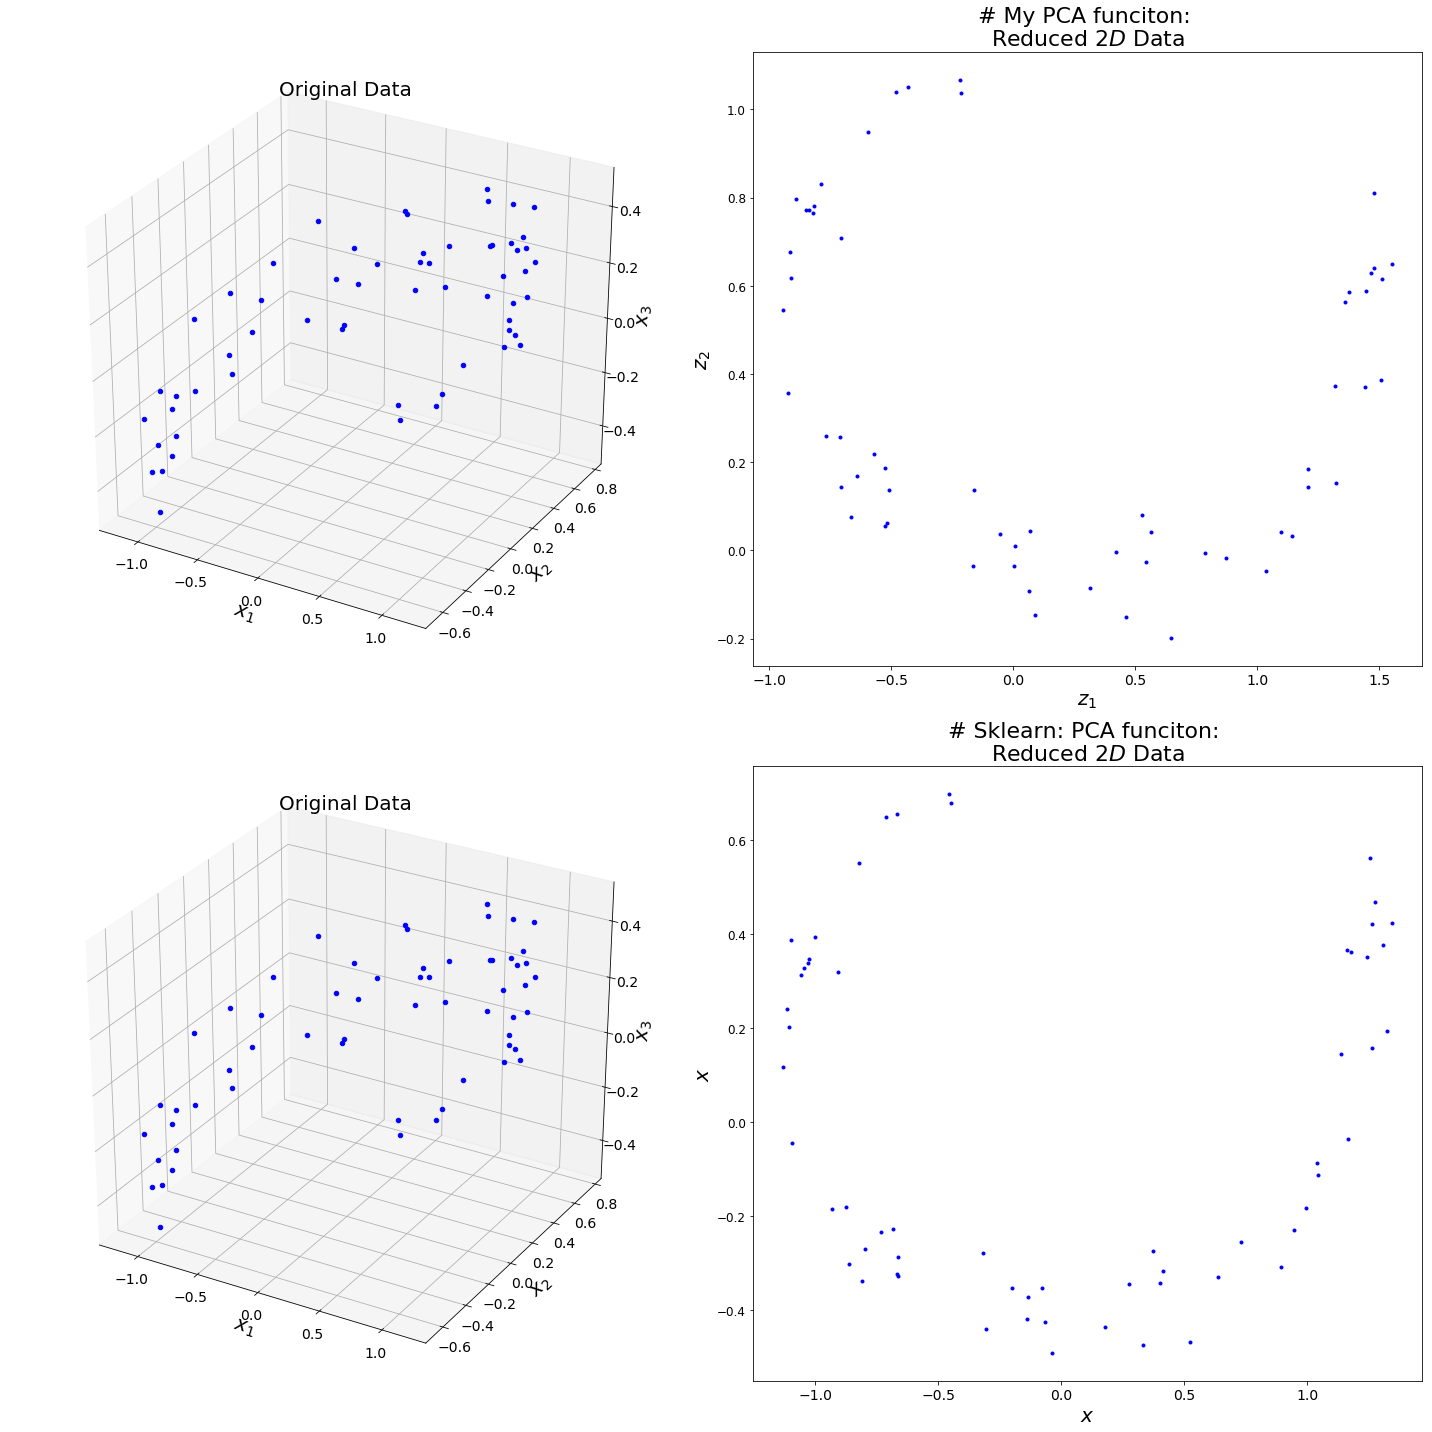

In [56]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(221, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c= "b", depthshade = False)
ax.set_xlabel(r"$x_1$", ha = "left" , fontsize = 20)
ax.set_ylabel(r"$x_2$", fontsize = 20)
ax.set_zlabel(r"$x_3$",rotation = 90 ,fontsize = 20 )
plt.title("Original Data", fontsize = 20)

plt.subplot(222)
plt.plot(Z[:,0], Z[:,1], "b.")
plt.xlabel(r"$z_1$", fontsize = 20)
plt.ylabel(r"$z_2$", fontsize = 20)
plt.title("# My PCA funciton: \nReduced $2D$ Data",
          fontsize = 22)

ax = fig.add_subplot(223, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c= "b", depthshade = False)
ax.set_xlabel(r"$x_1$", ha = "left" , fontsize = 20)
ax.set_ylabel(r"$x_2$", fontsize = 20)
ax.set_zlabel(r"$x_3$",rotation = 90 ,fontsize = 20 )
plt.title("Original Data", fontsize = 20)

plt.subplot(224)
plt.plot(X2D[:,0], X2D[:,1], "b.")
plt.xlabel(r"$x`_1$", fontsize = 20)
plt.ylabel(r"$x`_2$", fontsize = 20)
plt.title("# Sklearn: PCA funciton: \nReduced $2D$ Data",
          fontsize = 22)

save_fig("Comparing_Sklearn_my_code")

In [52]:
(X2D == Z).any()

False

This shows that though the projections look similar, there is some difference between my result and `sklearn's` result. 

After fitting the `PCA` transformer to the dataset, you can access the principal components using the `components_` variable (note that it contrains the principal components as horizontal vectors, so for example, the first principal component is equal to: 


In [58]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

## Explained Variance Ratio: 

- Another very useful piece of information is the _explained variance ratio_ of each principal component, available via the `explained_variance_ratio_` variable. 
- It indicates the proportion of the dataset's variance that lies along the axis of each principal component. 
- For example, let's look at the explained variance ratios of the first two components represented in the following figure: 
<img src = "images/dim_reduction/dataset_3d_plot.png">

In [59]:
pca.explained_variance_ratio_

array([ 0.84248607,  0.14631839])

- This tells you that 84.2% of the dataset's variance lies along the first axes and 14.6% lies along the second axis. 
- The leaves less that 1.2% for the third axis, so it is reasonable to assume that is probably carries little information. 

In [65]:
var_ret_master[-1]* 100, np.sum(pca.explained_variance_ratio_)*100

(97.828916666638492, 98.880446442931103)

- This means that my function explains $98\%$ of the variance in the dataset by using k = 2. 
- And `sklearn's` function explains $99\%$ of the variance in the dataset by using k =2. 

### Choosing the right number of dimensions: 
- Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance. (eg: $95\%$) 
- Unless, ofcourse, you are reducing dimensionality for data visualization -- in that case, you have no option but to reduce the dimensionality to 2 or 3 (max). 
- The following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to reserve $95\%$ of the training set's variance: 
```python
pca = PCA()
pca.fit(X_train)
# cumulative sum of variance contributed by each principal
# component axis
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 95) + 1 
```

- You could then set `n_components = d` and run PCA again. 
- However, there is a much better way: instead of specifying the number of principal components you want to preserve, you can set `n_components` to be a float `0.0` and `1.0`, indicating the ratio of variance you wish to preserve. 
```python
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)
```

- Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot `cumsum`). 
- There will usually be an elbow curve, where the explained variance stops growing fast. 
- You can think of this as the intrinsic(natural) dimensionality of the dataset. 
- In this case, you will be able to pin-point to a certain number of dimensions where the variance stops growing much, and you can use that as the `d` or `k` or the number of principal components. 

### PCA for Compression: 
- Obviously after dimensionality reduction, the training set takes up much less space. 
- For example, try applying PCA to MNIST dataset while preseving 95% of its variance. 
- You should find that each instance will have just 150 features, instead of the original 784 features. 
- So while most of the variance is preserved, the dataset is now less than $20\%$ of it's original size! 
- This is a reasonable compression ratio, and you can see how this can speed up a classification algorithm, such as SVM classifier temendously. 

# MNIST compression


In [75]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")

In [76]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

[0, 783, 0.097908503793450632, 0.99999999999999944]

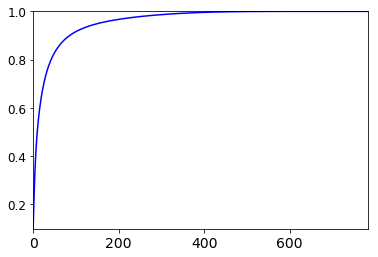

In [78]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
n = X_train.shape[1]
ks = np.arange(0,n)

[0, 783, 0.097908503793450632, 1.0099999999999993]

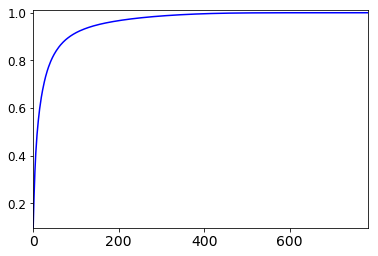

In [79]:
plt.plot(ks, cumsum, "b")
plt.axis([ks.min(), ks.max(), cumsum.min() , cumsum.max() + 0.01])

It seems to be slowing down at around 150 features but let's get an exact number: 

In [81]:
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [82]:
# Proving it further
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

In [88]:
X_reduced.shape

(52500, 154)

In [83]:
pca.n_components_ # exactly what we sawabove 

154

- It's also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. 
- Ofcourse, this won't give you back the original data since the projection lost a bit of information (within the $5\%$ variance that way dropped,  but it is likely to be quite close to the original data. 
- The mean squared distance between the original data and the reconstructed data (compresses and then decompressed) is called the _reconstruction error_. 
- __Note: __
    - This is the same as the  _projection error_ you learned ealier. That was the difference between the orignal dataset and it's projected version. 

In [90]:
V = pca.components_
V_reduce = V.T[:,:154]
V_reduce.shape
# >> (784, 154)
X_recovered_manually = X_reduced.dot(V_reduce.T)
X_recovered_manually.shape
# >> (52500, 784)

(52500, 784)

In [91]:
X_recovered = pca.inverse_transform(X_reduced)
X_recovered.shape

(52500, 784)

In [93]:
# There are some difference in both the equations 
(X_recovered_manually == X_recovered).any()

True

(-0.5, 27.5, 27.5, -0.5)

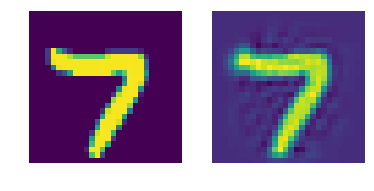

In [98]:
plt.subplot(121)
plt.imshow(X_train[0].reshape(28,28))
plt.axis("off")
plt.subplot(122)
plt.imshow(X_recovered[0].reshape(28,28))
plt.axis("off")

You can see that there is a slight image quality loss, but the digits are still mostly intact. 